## ✅ 1. PACKAGE MANAGEMENT

In [1]:
!pip install numpy==1.24.4
!pip install spacy==3.7.2
!python -m spacy download en_core_web_sm

  Using cached numpy-1.24.4.tar.gz (10.9 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [33 lines of output]
  Traceback (most recent call last):
    File "C:\Users\srswe\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 353, in <module>
      main()
    File "C:\Users\srswe\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 335, in main
      json_out['return_val'] = hook(**hook_input['kwargs'])
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    File "C:\Users\srswe\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 112, in get_requires_for_build_wheel
      backend = _build_backend()
                ^^^^^^^^^^^^^^^^
    File "C:\Users\srswe\anaconda3\Lib\site-packages\pip\_vendor\pyproject_hooks\_in_process\_in_process.py", line 77, in _build_backend
      obj = import_module(mod_path)
            ^^^^^^^^^^^^^^^^^^^^^

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     -- ------------------------------------- 0.8/12.8 MB 2.4 MB/s eta 0:00:06
     ---- ----------------------------------- 1.3/12.8 MB 2.3 MB/s eta 0:00:05
     ----- ---------------------------------- 1.8/12.8 MB 2.4 MB/s eta 0:00:05
     -------- ------------------------------- 2.6/12.8 MB 2.5 MB/s eta 0:00:05
     --------- ------------------------------ 3.1/12.8 MB 2.6 MB/s eta 0:00:04
     ------------ --------------------------- 3.9/12.8 MB 2.7 MB/s eta 0:00:04
     ------------- -------------------------- 4.5/12.8 MB 2.7 MB/s eta 0:00:04
     ---------------- ----------------------- 5.2/12.8 MB 2.8 MB/s eta 0:00:03
     ------------------ --------------------- 6.0/12.8 MB 2.9 MB/s eta 0:00:03
     --------------------- ------------------ 6.8/12.8 MB 3.0 MB/s eta 0:00:03
     ---------------------- ----------------- 7.3/12.8 MB 2.9 MB/s

## DATA LOADING

In [2]:
import pandas as pd
import os
file_path = os.path.join("data", "company_dataset.csv")
company_data = pd.read_csv(file_path)
company_data.head()

,Company Name,Website,Description,Industry,Location
0,Prime Holdings,https://www.primeholdings.com,We offer high-quality products in the mining &...,Mining & Metals,"Toronto, India"
1,Bright Farms,https://www.brightfarms.com,Specializing in innovative solutions for the i...,IT Services,"Amsterdam, France"
2,Eco Holdings,https://www.ecoholdings.com,Specializing in innovative solutions for the c...,Construction,"Berlin, Australia"
3,NextGen Industries,https://www.nextgenindustries.com,We offer high-quality products in the it servi...,IT Services,"Amsterdam, UK"
4,Global Consulting,https://www.globalconsulting.com,An established leader in electronics with a st...,Electronics,"Mumbai, Netherlands"


In [3]:
company_data.shape

(100, 5)

In [4]:
company_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Company Name  100 non-null    object
 1   Website       100 non-null    object
 2   Description   100 non-null    object
 3   Industry      100 non-null    object
 4   Location      100 non-null    object
dtypes: object(5)
memory usage: 4.0+ KB


## DATA PREPROCESSING

In [5]:
company_data["Location"] = company_data["Location"].apply(lambda x: x.split(",")[0].strip())
company_data["Location"]

0       Toronto
1     Amsterdam
2        Berlin
3     Amsterdam
4        Mumbai
        ...    
95     New York
96        Paris
97       London
98       Berlin
99       Sydney
Name: Location, Length: 100, dtype: object

In [6]:
company_data["Location"].value_counts()

Location
Berlin       14
New York     12
Toronto      11
Amsterdam    10
Mumbai       10
Tokyo        10
Sydney       10
Paris        10
London        7
Singapore     6
Name: count, dtype: int64

In [7]:
company_data["Industry"].value_counts()

Industry
Healthcare             8
Construction           8
Textiles               8
Electronics            7
Education              7
IT Services            7
Mining & Metals        6
Retail                 6
Utilities              5
Energy                 5
Finance                5
Aerospace & Defense    4
Logistics              4
Agriculture            4
Chemicals              4
Insurance              3
Biotechnology          3
Automotive             3
Food & Beverage        3
Name: count, dtype: int64

### CLEAN THE COMPANY DESCRIPTIONS

In [8]:
#Drop duplicates and  null values
company_data.drop_duplicates(inplace=True)
company_data.dropna(subset=['Description', 'Industry'], inplace=True)


import re
def clean_text(text):
    text = text.lower()                                # Lowercase
    text = re.sub(r"[^a-z\s]", " ", text)              # Remove punctuation and numbers
    text = re.sub(r"\s+", " ", text).strip()           # Remove extra spaces
    return text

# Apply to Description column
company_data["clean_description"] = company_data["Description"].apply(clean_text)

# Preview result
company_data[["Description", "clean_description"]].head(5)


,Description,clean_description
0,We offer high-quality products in the mining &...,we offer high quality products in the mining m...
1,Specializing in innovative solutions for the i...,specializing in innovative solutions for the i...
2,Specializing in innovative solutions for the c...,specializing in innovative solutions for the c...
3,We offer high-quality products in the it servi...,we offer high quality products in the it servi...
4,An established leader in electronics with a st...,an established leader in electronics with a st...


### TOKENIZATION & LEMMATIZATION + STOPWORD REMOVAL

In [9]:
!pip install spacy tqdm

In [10]:
import spacy
from tqdm import tqdm

# Load spaCy English model
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
tqdm.pandas()  # add progress bar

# Function: Lemmatize + remove stopwords
def tokenize_lemmatize(text):
    if not isinstance(text, str):
        return ""
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if token.is_alpha and not token.is_stop])

# Apply to cleaned description
company_data["tokens"] = company_data["clean_description"].progress_apply(tokenize_lemmatize)

# Preview result
company_data[["clean_description", "tokens"]].head()


100%|██████████| 100/100 [00:01<00:00, 66.04it/s]


,clean_description,tokens
0,we offer high quality products in the mining m...,offer high quality product mining metal industry
1,specializing in innovative solutions for the i...,specialize innovative solution service sector
2,specializing in innovative solutions for the c...,specialize innovative solution construction se...
3,we offer high quality products in the it servi...,offer high quality product service industry
4,an established leader in electronics with a st...,established leader electronic strong focus sus...


In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded= le.fit_transform(company_data['Industry'])
y_encoded

array([15, 12,  5, 12,  7,  2,  4,  7, 14,  2,  6, 17, 10,  0,  4, 11, 17,
       14, 12,  5,  7,  6,  7, 10, 16,  6, 15,  1,  5, 12, 11,  4,  1,  8,
       11,  5,  0, 12, 13, 13,  2, 17,  5,  8,  3,  1,  0, 16,  8, 16, 11,
       16, 18,  6, 16,  8, 11, 15, 15, 17,  5,  7, 17,  5, 18, 12,  8, 10,
        3, 13,  9,  6, 18, 14, 12,  6,  9,  7, 18,  3, 16, 14, 15, 17,  7,
        9,  9,  9,  1, 11, 17, 18,  4,  5, 15, 17,  6,  0, 11, 11])

## Why TF-IDF?
*Simple, fast, and interpretable
*Works well with classic ML models (like Logistic Regression, Naive Bayes)
*Captures which words are important per document, not just frequent
*No need for millions of rows or GPUs

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
vectorized = tfidf.fit_transform(company_data["tokens"])

print("TF-IDF matrix shape:", vectorized.shape)

TF-IDF matrix shape: (100, 177)


## SPILT THE DATA FOR TRAINING AND TESTING

In [29]:
from sklearn.model_selection import train_test_split

x = vectorized
y = y_encoded

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

print("Train set shape:", x_train.shape)
print("Test set shape:", x_test.shape)


Train set shape: (80, 177)
Test set shape: (20, 177)


## BALANCE THE IMBALANCE DATA

In [30]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np

ros = RandomOverSampler(random_state=42)
x_train_resampled, y_train_resampled = ros.fit_resample(x_train, y_train)

print("Before sampling:", dict(zip(*np.unique(y_train, return_counts=True))))
print("After sampling :", dict(zip(*np.unique(y_train_resampled, return_counts=True))))


Before sampling: {0: 3, 1: 3, 2: 2, 3: 2, 4: 3, 5: 7, 6: 6, 7: 6, 8: 4, 9: 4, 10: 2, 11: 7, 12: 6, 13: 2, 14: 3, 15: 5, 16: 5, 17: 6, 18: 4}
After sampling : {0: 7, 1: 7, 2: 7, 3: 7, 4: 7, 5: 7, 6: 7, 7: 7, 8: 7, 9: 7, 10: 7, 11: 7, 12: 7, 13: 7, 14: 7, 15: 7, 16: 7, 17: 7, 18: 7}


## EDA & Visualization

### Class Distribution (Before/After Oversampling)

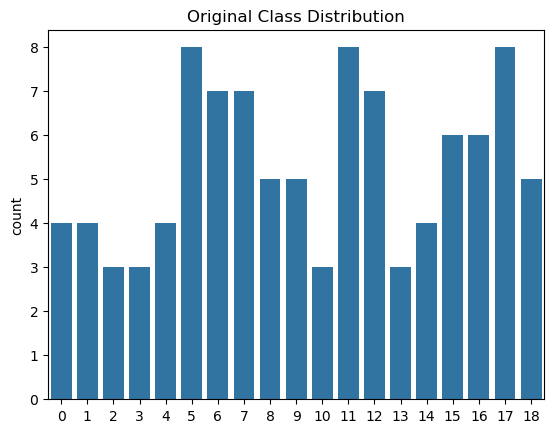

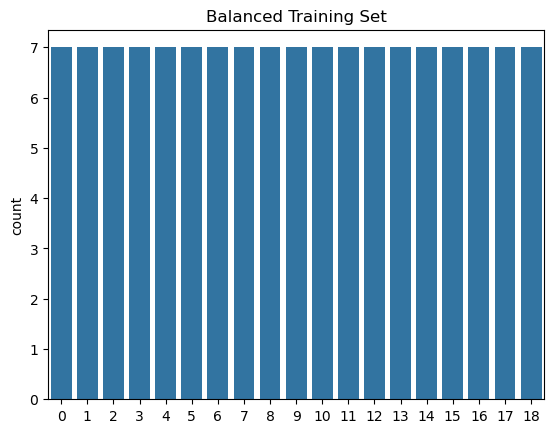

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Before oversampling
sns.countplot(x=y)
plt.title("Original Class Distribution")
plt.show()

# After oversampling
sns.countplot(x=y_train_resampled)
plt.title("Balanced Training Set")
plt.show()


<Axes: title={'center': 'Top 20 TF-IDF Words'}, xlabel='word'>

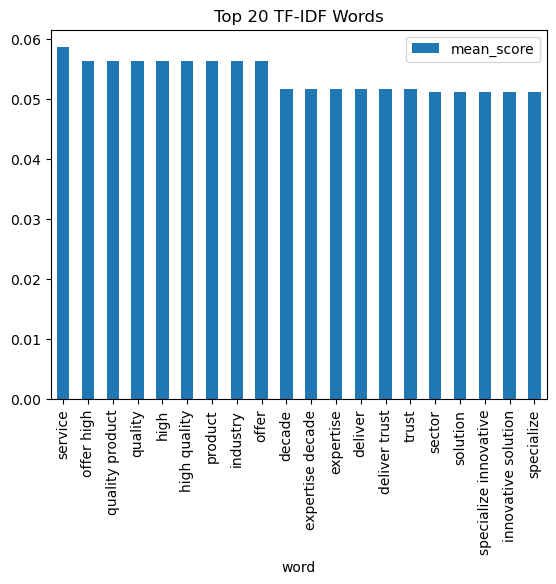

In [32]:
import numpy as np
import pandas as pd

# Get word scores
feature_names = tfidf.get_feature_names_out()
mean_tfidf = np.asarray(x.mean(axis=0)).flatten()

# Show top words
top_words = pd.DataFrame({
    "word": feature_names,
    "mean_score": mean_tfidf
}).sort_values(by="mean_score", ascending=False)

top_words.head(20).plot.bar(x='word', y='mean_score', title='Top 20 TF-IDF Words')

## MODEL BUILDING

In [33]:
#Multiclass Classification SUpervised Model
#Because you're using TF-IDF vectors (i.e., sparse, high-dimensional text data), the best-suited models are:
#1. Naive Bayes
#2.Logistic Regression

### Naive Bayes

In [34]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

nb_model = MultinomialNB()
nb_model.fit(x_train_resampled, y_train_resampled)

y_nb_pred = nb_model.predict(x_test)

print("Multinomial Naive Bayes")
print("Accuracy:", accuracy_score(y_test, y_nb_pred))
print(classification_report(y_test, y_nb_pred, target_names=le.classes_))


Multinomial Naive Bayes
Accuracy: 0.75
                     precision    recall  f1-score   support

Aerospace & Defense       1.00      1.00      1.00         1
        Agriculture       0.50      1.00      0.67         1
         Automotive       0.00      0.00      0.00         1
      Biotechnology       1.00      1.00      1.00         1
          Chemicals       0.00      0.00      0.00         1
       Construction       1.00      1.00      1.00         1
          Education       1.00      1.00      1.00         1
        Electronics       1.00      1.00      1.00         1
             Energy       1.00      1.00      1.00         1
            Finance       0.00      0.00      0.00         1
    Food & Beverage       1.00      1.00      1.00         1
         Healthcare       1.00      1.00      1.00         1
        IT Services       0.25      1.00      0.40         1
          Insurance       0.00      0.00      0.00         1
          Logistics       0.00      0.00     

C:\Users\srswe\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\srswe\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\srswe\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Logistic Regression:

In [35]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(x_train_resampled, y_train_resampled)
y_lr_pred = lr_model.predict(x_test)

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_lr_pred))
print(classification_report(y_test, y_lr_pred, target_names=le.classes_))


Logistic Regression
Accuracy: 0.8
                     precision    recall  f1-score   support

Aerospace & Defense       1.00      1.00      1.00         1
        Agriculture       1.00      1.00      1.00         1
         Automotive       0.00      0.00      0.00         1
      Biotechnology       1.00      1.00      1.00         1
          Chemicals       0.00      0.00      0.00         1
       Construction       1.00      1.00      1.00         1
          Education       1.00      1.00      1.00         1
        Electronics       1.00      1.00      1.00         1
             Energy       1.00      1.00      1.00         1
            Finance       0.00      0.00      0.00         1
    Food & Beverage       1.00      1.00      1.00         1
         Healthcare       1.00      1.00      1.00         1
        IT Services       0.33      1.00      0.50         1
          Insurance       0.00      0.00      0.00         1
          Logistics       1.00      1.00      1.00

C:\Users\srswe\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\srswe\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\srswe\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### SVM

In [41]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(x_train_resampled, y_train_resampled)
y_svm_pred = svm_model.predict(x_test)

print("Support Vector Machine")
print("Accuracy:", accuracy_score(y_test, y_svm_pred))
print(classification_report(y_test, y_svm_pred, target_names=le.classes_))


Support Vector Machine
Accuracy: 1.0
                     precision    recall  f1-score   support

Aerospace & Defense       1.00      1.00      1.00         1
        Agriculture       1.00      1.00      1.00         1
         Automotive       1.00      1.00      1.00         1
      Biotechnology       1.00      1.00      1.00         1
          Chemicals       1.00      1.00      1.00         1
       Construction       1.00      1.00      1.00         1
          Education       1.00      1.00      1.00         1
        Electronics       1.00      1.00      1.00         1
             Energy       1.00      1.00      1.00         1
            Finance       1.00      1.00      1.00         1
    Food & Beverage       1.00      1.00      1.00         1
         Healthcare       1.00      1.00      1.00         1
        IT Services       1.00      1.00      1.00         1
          Insurance       1.00      1.00      1.00         1
          Logistics       1.00      1.00      1

###  Cross-Validation for Logistic Regression

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np



lr_pipeline = ImbPipeline([
    ('oversample', RandomOverSampler(random_state=42)),
    ('logreg', LogisticRegression(max_iter=1000))
])

scores = cross_val_score(lr_pipeline, x, y, cv=5, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", scores)
print("Mean CV Accuracy: {:.2f}".format(np.mean(scores)))



C:\Users\srswe\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Cross-Validation Accuracy Scores: [0.8  0.75 0.8  0.85 0.5 ]
Mean CV Accuracy: 0.74


### Cross-Validation for SVM

In [38]:
from sklearn.model_selection import cross_val_score


svm_pipeline = ImbPipeline([
    ('oversample', RandomOverSampler(random_state=42)),
    ('svm', LinearSVC())
])


svm_cv_scores = cross_val_score(svm_pipeline, x, y, cv=5)
print("SVM Cross-Validation Scores:", svm_cv_scores)
print("Mean CV Accuracy:", svm_cv_scores.mean())


C:\Users\srswe\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


SVM Cross-Validation Scores: [1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0


## Confusion Matrix for SVM

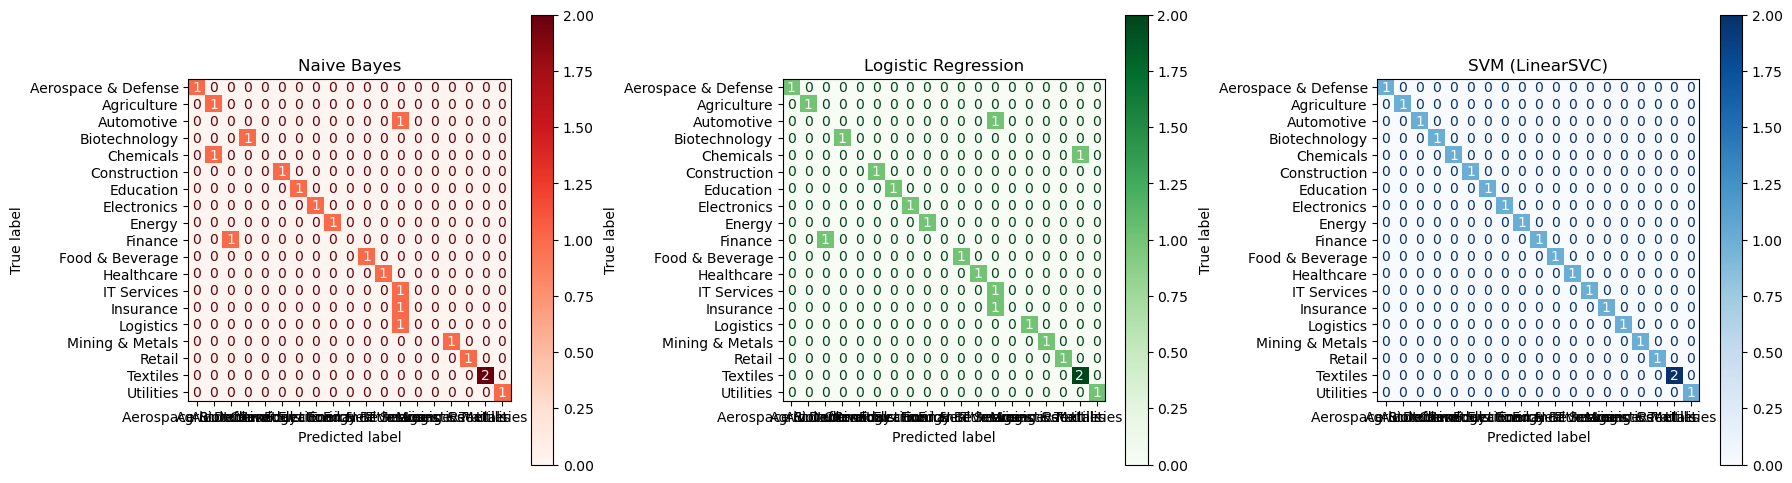

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Naive Bayes
ConfusionMatrixDisplay.from_predictions(
    y_test, y_nb_pred,
    display_labels=le.classes_,
    cmap="Reds",
    ax=axes[0]
)
axes[0].set_title("Naive Bayes")

# Logistic Regression
ConfusionMatrixDisplay.from_predictions(
    y_test, y_lr_pred,
    display_labels=le.classes_,
    cmap="Greens",
    ax=axes[1]
)
axes[1].set_title("Logistic Regression")

# SVM
ConfusionMatrixDisplay.from_predictions(
    y_test, y_svm_pred,
    display_labels=le.classes_,
    cmap="Blues",
    ax=axes[2]
)
axes[2].set_title("SVM (LinearSVC)")

# Final layout
plt.tight_layout()
plt.show()



## Testing Model with New Data

In [43]:
# Sample new data
new_descriptions = [
    "We develop AI-powered diagnostic tools for hospitals and medical research.",
    "Our firm offers cloud infrastructure, DevOps support, and cybersecurity solutions.",
    "We are one of the leading textile manufacturers and exporters in India.",
    "Tata Motors, a USD 42 billion organization, is a leading global automobile manufacturer of cars, utility vehicles, pick-ups, trucks and buses.",
    "Infosys Limited is an Indian multinational technology company that offers business consulting, information technology, and outsourcing services."
]

# Tokenize + Lemmatize
new_tokens = [tokenize_lemmatize(text) for text in new_descriptions]

# Use the original, already-fitted tfidf vectorizer
new_vectorized = tfidf.transform(new_tokens)

# Predict using trained models
lr_preds = lr_model.predict(new_vectorized)
svm_preds = svm_model.predict(new_vectorized)

# Decode
lr_labels = le.inverse_transform(lr_preds)
svm_labels = le.inverse_transform(svm_preds)

# Display
for i, desc in enumerate(new_descriptions):
    print(f"\n {desc}")
    print(f"Logistic Regression → {lr_labels[i]}")
    print(f"SVM (LinearSVC)     → {svm_labels[i]}")



 We develop AI-powered diagnostic tools for hospitals and medical research.
Logistic Regression → Healthcare
SVM (LinearSVC)     → Healthcare

 Our firm offers cloud infrastructure, DevOps support, and cybersecurity solutions.
Logistic Regression → IT Services
SVM (LinearSVC)     → IT Services

 We are one of the leading textile manufacturers and exporters in India.
Logistic Regression → Textiles
SVM (LinearSVC)     → Textiles

 Tata Motors, a USD 42 billion organization, is a leading global automobile manufacturer of cars, utility vehicles, pick-ups, trucks and buses.
Logistic Regression → Utilities
SVM (LinearSVC)     → Utilities

 Infosys Limited is an Indian multinational technology company that offers business consulting, information technology, and outsourcing services.
Logistic Regression → IT Services
SVM (LinearSVC)     → IT Services


In [45]:
import joblib

# Save TF-IDF Vectorizer
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

# Save Trained Models
joblib.dump(lr_model, "logreg_model.pkl")
joblib.dump(svm_model, "svm_model.pkl")

# Save Label Encoder
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']